In [232]:
# Import packages
import os
import numpy as np
import matplotlib.pyplot as plt
from firedrake import *
from tqdm.auto import tqdm
from numpy.random import default_rng
import matplotlib.pyplot as plt
from firedrake.meshadapt import *
import time

In [233]:
from firedrake import Constant, cos, sin, Function, SpatialCoordinate, sqrt
from firedrake import assemble, FacetNormal, avg, jump,pi
from firedrake.cython.dmcommon import create_section
import movement.solver_parameters as solver_parameters
from firedrake.petsc import PETSc
from pyadjoint import no_annotations
import ufl
import numpy as np
import matplotlib.pyplot as plt

In [234]:
#doing modification for monge_ampere move:
class PrimeMover(object):
    """
    Base class for all mesh movers.
    """
    def __init__(self, mesh, monitor_function=None, **kwargs):
        self.mesh = mesh
        self.monitor_function = monitor_function
        self.dim = mesh.topological_dimension()
        if self.dim != 2:
            raise NotImplementedError(f"Dimension {self.dim} has not been considered yet")
        self.gdim = mesh.geometric_dimension()
        self.plex = self.mesh.topology_dm
        self.vertex_indices = self.plex.getDepthStratum(0)
        self.edge_indices = self.plex.getDepthStratum(1)

        # Measures
        degree = kwargs.get('quadrature_degree')
        self.dx = dx(domain=mesh, degree=degree)
        self.ds = ds(domain=mesh, degree=degree)
        self.dS = dS(domain=mesh, degree=degree)

        # Mesh coordinate functions
        self.coord_space = mesh.coordinates.function_space()
        # Mesh coordinate functions comment:下面的 self.xi 是不会发生变化的，所以叫 Computational coordinates
        self._x = Function(mesh.coordinates, name="Physical coordinates")
        self.xi = Function(mesh.coordinates, name="Computational coordinates")
        self.v = Function(self.coord_space, name="Mesh velocity")

    def _get_coordinate_section(self):
        entity_dofs = np.zeros(self.dim+1, dtype=np.int32)
        entity_dofs[0] = self.gdim
        self._coordinate_section = create_section(self.mesh, entity_dofs)
        dm_coords = self.plex.getCoordinateDM()
        dm_coords.setDefaultSection(self._coordinate_section)
        self._coords_local_vec = dm_coords.createLocalVec()
        self._update_plex_coordinates()

    def _update_plex_coordinates(self):
        if not hasattr(self, '_coords_local_vec'):
            self._get_coordinate_section()
        self._coords_local_vec.array[:] = np.reshape(
            self.mesh.coordinates.dat.data_with_halos,
            self._coords_local_vec.array.shape,
        )
        self.plex.setCoordinatesLocal(self._coords_local_vec)

    def _get_edge_vector_section(self):
        entity_dofs = np.zeros(self.dim+1, dtype=np.int32)
        entity_dofs[1] = 1
        self._edge_vector_section = create_section(self.mesh, entity_dofs)

    def coordinate_offset(self, index):
        """
        Get the DMPlex coordinate section offset
        for a given `index`.
        """
        if not hasattr(self, '_coordinate_section'):
            self._get_coordinate_section()
        return self._coordinate_section.getOffset(index)//self.dim

    def edge_vector_offset(self, index):
        """
        Get the DMPlex edge vector section offset
        for a given `index`.
        """
        if not hasattr(self, '_edge_vector_section'):
            self._get_edge_vector_section()
        return self._edge_vector_section.getOffset(index)

    def coordinate(self, index):
        """
        Get the mesh coordinate associated with
        a given `index`.
        """
        return self.mesh.coordinates.dat.data_with_halos[self.get_offset(index)]

    def move(self):
        """
        Move the mesh according to the method of choice.
        """
        raise NotImplementedError("Implement `move` in the derived class.")

    def adapt(self):
        """
        Alias of `move`.
        """
        from warnings import warn
        warn("`adapt` is deprecated (use `move` instead)", DeprecationWarning, stacklevel=2)
        return self.move()

In [235]:
class MongeAmpereMover_Base(PrimeMover):
    """
    Base class for mesh movers based on the solution
    of Monge-Ampere type equations.
    """
    residual_l2_form = 0
    norm_l2_form = 0
    phi_old = None

    def __init__(self, mesh, monitor_function,**kwargs):
        """
        :arg mesh: the physical mesh
        :arg monitor_function: a Python function which takes a mesh as input
        :kwarg phi_init: initial guess for the scalar potential
        :kwarg sigma_init: initial guess for the Hessian
        :kwarg maxiter: maximum number of iterations for the relaxation
        :kwarg rtol: relative tolerance for the residual
        :kwarg dtol: divergence tolerance for the residual
        :kwarg fix_boundary_nodes: should all boundary nodes remain fixed?
        """
        if monitor_function is None:
            raise ValueError("Please supply a monitor function")

        
        # Collect parameters before calling super
        self.pseudo_dt = Constant(kwargs.pop('pseudo_timestep', 0.1))
        self.maxiter = kwargs.pop('maxiter', 1000)
        self.rtol = kwargs.pop('rtol', 1e-3)
        self.dtol = kwargs.pop('dtol', 2.0)
        self.fix_boundary_nodes = kwargs.pop('fix_boundary_nodes', False)
        super().__init__(mesh, monitor_function = monitor_function)

        # Create function spaces
        self.P0 = FunctionSpace(mesh, "DG", 0)
        self.P1 = FunctionSpace(mesh, "CG", 1)
        self.P1_vec = VectorFunctionSpace(mesh, "CG", 1)
        self.P1_ten = TensorFunctionSpace(mesh, "CG", 1)

        # Create objects used during the mesh movement
        self.theta = Constant(0.0)
        self.monitor = Function(self.P1, name="Monitor function")
        self.monitor.interpolate(self.monitor_function(self.mesh))
        self.volume = Function(self.P0, name="Mesh volume")
        self.volume.interpolate(ufl.CellVolume(mesh))
        self.original_volume = Function(self.volume)
        self.total_volume = assemble(Constant(1.0)*self.dx)
        self.L_P0 = TestFunction(self.P0)*self.monitor*self.dx
        self._grad_phi = Function(self.P1_vec)
        self.grad_phi = Function(self.mesh.coordinates)

    @PETSc.Log.EventDecorator("MongeAmpereBase.apply_initial_guess")
    def apply_initial_guess(self, phi_init=None, sigma_init=None, **kwargs):
        """
        Initialise the approximations to the scalar potential
        and its hessian with an initial guess.

        By default, both are initialised to zero, which corresponds
        to the case where the computational and physical meshes
        coincide.

        :kwarg phi_init: initial guess for the scalar potential
        :kwarg sigma_init: initial guess for the Hessian
        """

        if phi_init is not None and sigma_init is not None:
            self.phi.assign(phi_init)
            self.sigma.assign(sigma_init)
            self.phi_old.assign(phi_init)
            self.sigma_old.assign(sigma_init)
        elif phi_init is not None or sigma_init is not None:
            raise ValueError("Need to initialise both phi *and* sigma")

        
    @property
    @PETSc.Log.EventDecorator("MongeAmpereBase.diagnostics")
    def diagnostics(self):
        """
        Compute diagnostics:
          1) the ratio of the smallest and largest element volumes;
          2) equidistribution of elemental volumes;
          3) relative L2 norm residual.
        """
        v = self.volume.vector().gather()
        minmax = v.min()/v.max()
        mean = v.sum()/v.max()
        w = v.copy() - mean
        w *= w
        std = np.sqrt(w.sum()/w.size)
        equi = std/mean
        residual_l2 = assemble(self.residual_l2_form).dat.norm
        norm_l2 = assemble(self.norm_l2_form).dat.norm
        residual_l2_rel = residual_l2/norm_l2
        return minmax, residual_l2_rel, equi

    @property
    @PETSc.Log.EventDecorator("MongeAmpereBase.update_coordinates")
    def x(self):
        """
        Update the coordinate :class:`Function` using
        the recovered gradient.
        """
        try:
            self.grad_phi.assign(self._grad_phi)
        except Exception:
            self.grad_phi.interpolate(self._grad_phi)
        self._x.assign(self.xi + self.grad_phi)  # x = ξ + grad(φ)
        return self._x
    
    @property
    @PETSc.Log.EventDecorator("MongeAmpereBase.create_l2_projector")
    def l2_projector(self):
        if hasattr(self, '_l2_projector'):
            return self._l2_projector
        u_cts = TrialFunction(self.P1_vec)
        v_cts = TestFunction(self.P1_vec)

        # Domain interior
        phi_grad_v_dx = ufl.inner(v_cts, ufl.grad(self.phi_old))*self.dx
        a = ufl.inner(v_cts, u_cts)*self.dx
        L = phi_grad_v_dx

        # Enforce no movement normal to boundary
        n = ufl.FacetNormal(self.mesh)
        bcs = []
        for i in self.mesh.exterior_facets.unique_markers:
            if self.fix_boundary_nodes:
                bcs.append(DirichletBC(self.P1_vec, 0, i))
                continue

            # Check for axis-aligned boundaries
            _n = [assemble(abs(n[j])*self.ds(i)) for j in range(self.dim)]
            if np.allclose(_n, 0.0):
                raise ValueError(f"Invalid normal vector {_n}")
            else:
                if np.isclose(_n[0], 0.0):
                    bcs.append(DirichletBC(self.P1_vec.sub(1), 0, i))
                    continue
                elif np.isclose(_n[1], 0.0):
                    bcs.append(DirichletBC(self.P1_vec.sub(0), 0, i))
                    continue

            a_bc = ufl.dot(v_cts, n)*ufl.dot(u_cts, n)*self.ds
            bcs.append(EquationBC(a_bc == 0, self._grad_phi, i))

            s = ufl.perp(n)
            a_bc = ufl.dot(v_cts, s)*ufl.dot(u_cts, s)*self.ds
            L_bc = ufl.dot(v_cts, s)*phi_grad_v_dx
            bcs.append(EquationBC(a_bc == L_bc, self._grad_phi, i))

        # Create solver
        problem = LinearVariationalProblem(a, L, self._grad_phi, bcs=bcs)
        sp = {
            "ksp_type": "cg",
            "pc_type": "bjacobi",
            "sub_pc_type": "ilu",
        }
        self._l2_projector = LinearVariationalSolver(problem, solver_parameters=sp)
        return self._l2_projector

In [236]:
class MongeAmpereMover_Combined(MongeAmpereMover_Base):
    
    @PETSc.Log.EventDecorator("MongeAmpereMover.__init__")
    def __init__(self, mesh, monitor_function, method,**kwargs):
        """
        :arg mesh: the physical mesh
        :arg monitor_function: a Python function which takes a mesh as input
        :kwarg method: choose from 'relaxation' and 'quasi_newton'
        :arg u: user input
        :kwarg phi_init: initial guess for the scalar potential
        :kwarg sigma_init: initial guess for the Hessian
        :kwarg pseudo_timestep: pseudo-timestep to use for the relaxation (only for relaxation)
        :kwarg maxiter: maximum number of iterations for the method
        :kwarg rtol: relative tolerance for the residual
        :kwarg dtol: divergence tolerance for the residual
        """
        assert method in ['relaxation', 'quasi_newton'], "Method must be either 'relaxation' or 'quasi_newton'."
        
        self.method = 'relaxation'

        super().__init__(mesh, monitor_function=monitor_function,**kwargs)
        # Specific setup for relaxation
        if self.method == 'relaxation':
            self.pseudo_dt = Constant(kwargs.pop('pseudo_timestep', 0.1))
            self.phi = Function(self.P1)
            self.sigma = Function(self.P1_ten)
            self.phi_old = Function(self.P1)
            self.sigma_old = Function(self.P1_ten)
            self.apply_initial_guess(**kwargs)
            # Setup residuals
            I = ufl.Identity(self.dim)
            self.theta_form = self.monitor*ufl.det(I + self.sigma_old)*self.dx
            self.residual = self.monitor*ufl.det(I + self.sigma_old) - self.theta
            psi = TestFunction(self.P1)
            self.residual_l2_form = psi*self.residual*self.dx
            self.norm_l2_form = psi*self.theta*self.dx

        # Specific setup for quasi_newton
        elif self.method == 'quasi_newton':
            print("set up newton")
            self.V = self.P1*self.P1_ten
            self.phisigma = Function(self.V)
            self.phi, self.sigma = self.phisigma.split()
            self.phisigma_old = Function(self.V)
            self.phi_old, self.sigma_old = self.phisigma_old.split()
            # Initialise phi and sigma
            self.apply_initial_guess(**kwargs)
            # Setup residuals
            I = ufl.Identity(self.dim)
            self.theta_form = self.monitor*ufl.det(I + self.sigma_old)*self.dx
            self.residual = self.monitor*ufl.det(I + self.sigma_old) - self.theta
            psi = TestFunction(self.P1)
            self.residual_l2_form = psi*self.residual*self.dx
            self.norm_l2_form = psi*self.theta*self.dx

    
    def switch_method(self, new_method, **kwargs):
        """
        Switch between the relaxation and quasi_newton methods.
        """
        assert new_method in ['relaxation', 'quasi_newton'], "New method must be either 'relaxation' or 'quasi_newton'."

        # If we're not actually switching methods, just return
        if self.method == new_method:
            return

        self.method = new_method
        print(self.method)
        # Re-setup based on the new method
        if self.method == 'relaxation':
            self.pseudo_dt = Constant(kwargs.pop('pseudo_timestep', 0.1))
            self.phi = Function(self.P1)
            self.sigma = Function(self.P1_ten)
            self.phi_old = Function(self.P1)
            self.sigma_old = Function(self.P1_ten)
            self.apply_initial_guess(**kwargs)
            # Setup residuals
            I = ufl.Identity(self.dim)
            self.theta_form = self.monitor*ufl.det(I + self.sigma_old)*self.dx
            self.residual = self.monitor*ufl.det(I + self.sigma_old) - self.theta
            psi = TestFunction(self.P1)
            self.residual_l2_form = psi*self.residual*self.dx
            self.norm_l2_form = psi*self.theta*self.dx

        elif self.method == 'quasi_newton':
            print("set up newton")
            self.V = self.P1*self.P1_ten
            self.phisigma = Function(self.V)
            self.phi, self.sigma = self.phisigma.split()
            self.phisigma_old = Function(self.V)
            self.phi_old, self.sigma_old = self.phisigma_old.split()
            # Initialise phi and sigma
            self.apply_initial_guess(**kwargs)
            # Setup residuals
            I = ufl.Identity(self.dim)
            self.theta_form = self.monitor*ufl.det(I + self.sigma_old)*self.dx
            self.residual = self.monitor*ufl.det(I + self.sigma_old) - self.theta
            psi = TestFunction(self.P1)
            self.residual_l2_form = psi*self.residual*self.dx
            self.norm_l2_form = psi*self.theta*self.dx
            print("switch to newton success")
       
    
    @property
    @PETSc.Log.EventDecorator("MongeAmpereMover.create_pseudotimestepper")
    def pseudotimestepper(self):

        phi = TrialFunction(self.P1)
        psi = TestFunction(self.P1)
        a = ufl.inner(ufl.grad(psi), ufl.grad(phi))*self.dx
        L = ufl.inner(ufl.grad(psi), ufl.grad(self.phi))*self.dx \
            + self.pseudo_dt*psi*self.residual*self.dx
        problem = LinearVariationalProblem(a, L, self.phi)
        sp = {
            "ksp_type": "cg",
            "pc_type": "gamg",
        }
        nullspace = VectorSpaceBasis(constant=True, comm=PETSc.COMM_WORLD)
        self._pseudotimestepper = LinearVariationalSolver(
            problem, solver_parameters=sp,
            nullspace=nullspace, transpose_nullspace=nullspace,
        )
        return self._pseudotimestepper
    
    @property
    @PETSc.Log.EventDecorator("MongeAmpereMover.create_equidistributor")
    def equidistributor(self):
        """
        Setup the equidistributor for the relaxation method.
        """
        if hasattr(self, '_equidistributor'):
            return self._equidistributor
        if self.dim != 2:
            raise NotImplementedError  # TODO
        n = ufl.FacetNormal(self.mesh)
        sigma = TrialFunction(self.P1_ten)
        tau = TestFunction(self.P1_ten)
        a = ufl.inner(tau, sigma)*self.dx
        L = -ufl.dot(ufl.div(tau), ufl.grad(self.phi))*self.dx \
            + (tau[0, 1]*n[1]*self.phi.dx(0) + tau[1, 0]*n[0]*self.phi.dx(1))*self.ds
        problem = LinearVariationalProblem(a, L, self.sigma)
        sp = {
            "ksp_type": "cg",
            "pc_type": "bjacobi",
            "sub_pc_type": "ilu",
        }
        self._equidistributor = LinearVariationalSolver(problem, solver_parameters=sp)
        return self._equidistributor
    
    @property
    @PETSc.Log.EventDecorator("MongeAmpereMover.create_equidistributor_quasi")
    def equidistributor_quasi(self):
        """
        Setup the equidistributor for the quasi-newton method.
        """
        if self.dim != 2:
            raise NotImplementedError  # TODO
        n = ufl.FacetNormal(self.mesh)
        I = ufl.Identity(self.dim)
        phi, sigma = split(self.phisigma)
        psi, tau = TestFunctions(self.V)
        F = ufl.inner(tau, sigma)*self.dx \
            + ufl.dot(ufl.div(tau), ufl.grad(phi))*self.dx \
            - (tau[0, 1]*n[1]*phi.dx(0) + tau[1, 0]*n[0]*phi.dx(1))*self.ds \
            - psi*(self.monitor*ufl.det(I + sigma) - self.theta)*self.dx
        phi, sigma = TrialFunctions(self.V)
        
        @PETSc.Log.EventDecorator("MongeAmpereMover.update_monitor")
        def update_monitor(cursol):
            """
            Callback for updating the monitor function.
            """
            with self.phisigma_old.dat.vec as v:
                cursol.copy(v)
            self.l2_projector.solve()
            self.mesh.coordinates.assign(self.x)
            self.monitor.interpolate(self.monitor_function(self.mesh))
            self.mesh.coordinates.assign(self.xi)
            self.theta.assign(assemble(self.theta_form)*self.total_volume**(-1))

        # Custom preconditioner
        Jp = ufl.inner(tau, sigma)*self.dx \
            + phi*psi*self.dx \
            + ufl.inner(ufl.grad(phi), ufl.grad(psi))*self.dx

        # Setup the variational problem
        problem = NonlinearVariationalProblem(F, self.phisigma, Jp=Jp)
        nullspace = MixedVectorSpaceBasis(self.V, [VectorSpaceBasis(constant=True), self.V.sub(1)])
        sp = solver_parameters.serial_qn if COMM_WORLD.size == 1 else solver_parameters.parallel_qn
        sp['snes_atol'] = self.rtol
        sp['snes_max_it'] = self.maxiter
        self._equidistributor_quasi = NonlinearVariationalSolver(problem,
                                                                     nullspace=nullspace,
                                                                     transpose_nullspace=nullspace,
                                                                     pre_function_callback=update_monitor,
                                                                     pre_jacobian_callback=update_monitor,
                                                                     solver_parameters=sp)
        @no_annotations
        @PETSc.Log.EventDecorator("MongeAmpereMover.monitor")
        def monitor(snes, i, rnorm):
            """
            Print progress of the optimisation to screen.

            Note that convergence is not actually checked.
            """
            cursol = snes.getSolution()
            update_monitor(cursol)
            self.mesh.coordinates.assign(self.x)
            assemble(self.L_P0, tensor=self.volume)
            self.volume.interpolate(self.volume/self.original_volume)
            self.mesh.coordinates.assign(self.xi)
            minmax, residual, equi = self.diagnostics
            PETSc.Sys.Print(f"{i:4d}"
                            f"   Min/Max {minmax:10.4e}"
                            f"   Residual {residual:10.4e}"
                            f"   Equidistribution {equi:10.4e}")

        self.snes = self._equidistributor_quasi.snes
        self.snes.setMonitor(monitor)
        print("calculation of quasi completed")
        return self._equidistributor_quasi
    
    @PETSc.Log.EventDecorator("MongeAmpereMover.move")
    def move(self):
        """
        Run the selected method to convergence and update the mesh.
        """
        residuals = []
        if self.method == 'relaxation':
            for i in range(self.maxiter):
                # lz project
                self.l2_projector.solve()

                # Update mesh coordinates
                self.mesh.coordinates.assign(self.x)

                # Update monitor function
                self.monitor.interpolate(self.monitor_function(self.mesh))
                assemble(self.L_P0, tensor=self.volume)
                self.volume.interpolate(self.volume / self.original_volume)
                self.mesh.coordinates.assign(self.xi)

                # Evaluate normalisation coefficient
                self.theta.assign(assemble(self.theta_form) / self.total_volume)

                # Check convergence criteria
                minmax, residual, equi = self.diagnostics
                residuals.append(residual)
                if i == 0:
                    initial_norm = residual
                PETSc.Sys.Print(f"{i:4d}"
                f"   Min/Max {minmax:10.4e}"
                f"   Residual {residual:10.4e}"
                f"   Equidistribution {equi:10.4e}")
                if residual < self.rtol:
                    PETSc.Sys.Print(f"Converged in {i+1} iterations using Relaxation.")
                    break

                if i > 0 and residuals[i] > residuals[i-1]:
                    PETSc.Sys.Print(f"Relaxation method is diverging after {i+1} iterations.")
                    PETSc.Sys.Print(f"Switching to Newton method.")
                    self.switch_method('quasi_newton')
                    print("switch_method is excecuted")
                    break  # Exiting the relaxation loop

                if residual > self.dtol*initial_norm:
                    raise ConvergenceError(f"Diverged after {i+1} iterations.")
                
                if i == self.maxiter-1:
                    raise ConvergenceError(f"Failed to converge in {i+1} iterations.")

                # Apply pseudotimestepper and equidistributor
                self.pseudotimestepper.solve()
                self.equidistributor.solve()
                self.phi_old.assign(self.phi)
                self.sigma_old.assign(self.sigma)

            if self.method == 'quasi_newton':
                self.equidistributor_quasi.solve()
                print("Newton is excecuted")
                i = self.snes.getIterationNumber()
                PETSc.Sys.Print(f"Converged in {i} iterations.")
            self.mesh.coordinates.assign(self.x)
            return i
        
        
def monge_ampere(mesh, monitor_function,method='relaxation', **kwargs):
    r"""
    Movement of a `mesh` is determined by a `monitor_function`
    :math:`m` and the Monge-Ampère type equation

..  math::
        m(x)\det(I + H(\phi)) = \theta,

    for a scalar potential :math:`\phi`, where :math:`I` is the
    identity matrix, :math:`\theta` is a normalisation coefficient
    and :math:`H(\phi)` denotes the Hessian of :math:`\phi` with
    respect to the coordinates :math:`\xi` of the computational mesh.

    The physical mesh coordinates :math:`x` are updated according to

..  math::
        x = \xi + \nabla\phi.

    :arg mesh: the physical mesh
    :arg monitor_function: a Python function which takes a mesh as input
    :kwarg method: choose from 'relaxation' and 'quasi_newton'
    :kwarg phi_init: initial guess for the scalar potential
    :kwarg sigma_init: initial guess for the Hessian
    :return: converged scalar potential and Hessian
    """
    if method == 'relaxation':
        mover = MongeAmpereMover_Combined(mesh, monitor_function,**kwargs)
    else:
        raise ValueError(f"Monge-Ampere solver {method} not recognised.")
    mover.adapt()
    return mover.phi, mover.sigma

In [237]:
def MongeAmpereMover(mesh, monitor_function, method='relaxation', **kwargs):
    r"""
    Movement of a `mesh` is determined by a `monitor_function`
    :math:`m` and the Monge-Ampère type equation

    ..  math::
        m(x)\det(I + H(\phi)) = \theta,

    for a scalar potential :math:`\phi`, where :math:`I` is the
    identity matrix, :math:`\theta` is a normalisation coefficient
    and :math:`H(\phi)` denotes the Hessian of :math:`\phi` with
    respect to the coordinates :math:`\xi` of the computational mesh.

    The physical mesh coordinates :math:`x` are updated according to

    ..  math::
        x = \xi + \nabla\phi.

    :arg mesh: the physical mesh
    :arg monitor_function: a Python function which takes a mesh as input
    :arg u: the numerical sol of u to calculate m(x)
    :kwarg method: choose from 'relaxation' and 'quasi_newton'
    :return: converged scalar potential and Hessian
    """
    if method == 'relaxation':
        return MongeAmpereMover_Combined(mesh, monitor_function,method,**kwargs)
    else:
        raise ValueError(f"Method {method} not recognised.")

In [238]:
function_spaces_r = []
spatial_coordinates_r = []
u_s = []
adapted_meshes = []
elapsed_times = []

for i in range(10, 101, 10): # Iterates from 10 to 40, in steps of 10
    mesh = UnitSquareMesh(i,i)
    V = FunctionSpace(mesh, 'CG', 1)
    x, y = SpatialCoordinate(mesh)

    u = Function(V)
    v = TestFunction(V)

    x,y = SpatialCoordinate(mesh)
    f = Function(V)
    f.interpolate(sin(x*pi)*sin(2*y*pi))


    bcs = DirichletBC(V, Constant(2.0), (1,))

    F = (inner(grad(u), grad(v)) - inner(f, v)) * dx
    solve(F == 0, u, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'}, bcs=bcs)
    u_s.append(u)

    start_time = time.time()
    def pde_monitor(mesh):

        # Define the Riemannian metric
        P1_tensor = TensorFunctionSpace(mesh, "CG", 1)
        metric = RiemannianMetric(P1_tensor)

        # Compute the Hessian of the current solution
        #注意，计算hessian矩阵的过程是否可以优化或者加速
        hessian = metric.compute_hessian(u)

        P1 = FunctionSpace(mesh, "CG", 1)
        
        beta = Constant(1)
        Hnorm = Function(P1).interpolate(sqrt(inner(hessian, hessian)))
        Hnorm_max = Hnorm.dat.data[:].max()                                 
        monitor = 1 + beta * Hnorm/Hnorm_max
        
        return monitor
    mover = MongeAmpereMover(mesh, pde_monitor, method="relaxation")
    mover.move()
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_times.append(elapsed_time)
    print(f"Time taken for movement for {i}x{i} Mesh: {elapsed_time} seconds")
    adapted_meshes.append(mesh)

   0   Min/Max 5.5039e-01   Residual 1.2128e-01   Equidistribution 9.9021e-01
   1   Min/Max 5.8612e-01   Residual 1.0851e-01   Equidistribution 9.9063e-01
   2   Min/Max 6.2099e-01   Residual 9.7403e-02   Equidistribution 9.9098e-01
   3   Min/Max 6.5468e-01   Residual 8.7645e-02   Equidistribution 9.9128e-01
   4   Min/Max 6.8685e-01   Residual 7.9005e-02   Equidistribution 9.9154e-01
   5   Min/Max 7.1714e-01   Residual 7.1309e-02   Equidistribution 9.9176e-01
   6   Min/Max 7.4513e-01   Residual 6.4417e-02   Equidistribution 9.9194e-01
   7   Min/Max 7.6275e-01   Residual 5.8218e-02   Equidistribution 9.9202e-01
   8   Min/Max 7.7546e-01   Residual 5.2625e-02   Equidistribution 9.9207e-01
   9   Min/Max 7.8970e-01   Residual 4.6536e-02   Equidistribution 9.9214e-01
  10   Min/Max 8.0628e-01   Residual 3.9724e-02   Equidistribution 9.9224e-01
  11   Min/Max 8.1704e-01   Residual 3.3936e-02   Equidistribution 9.9234e-01
  12   Min/Max 8.2612e-01   Residual 2.9053e-02   Equidistributi

/home/liyongqi/Desktop/install_firedrake_adapt/firedrake-adapt/src/firedrake/firedrake/function.py:318: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


  57   Min/Max 9.1938e-01   Residual 1.8236e-03   Equidistribution 9.9957e-01
Relaxation method is diverging after 58 iterations.
Switching to Newton method.
quasi_newton
set up newton
switch to newton success
switch_method is excecuted
calculation of quasi completed
   0   Min/Max 9.1938e-01   Residual 1.5905e-01   Equidistribution 9.9957e-01
   1   Min/Max 9.1938e-01   Residual 5.8635e-03   Equidistribution 9.9957e-01
Newton is excecuted
Converged in 1 iterations.
Time taken for movement for 40x40 Mesh: 28.28844690322876 seconds
   0   Min/Max 5.1410e-01   Residual 1.4171e-01   Equidistribution 9.9960e-01
   1   Min/Max 5.5950e-01   Residual 1.2890e-01   Equidistribution 9.9962e-01
   2   Min/Max 6.0674e-01   Residual 1.1704e-01   Equidistribution 9.9964e-01
   3   Min/Max 6.4572e-01   Residual 1.0616e-01   Equidistribution 9.9965e-01
   4   Min/Max 6.7781e-01   Residual 9.6192e-02   Equidistribution 9.9966e-01
   5   Min/Max 7.0030e-01   Residual 8.7068e-02   Equidistribution 9.9967

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


  29   Min/Max 8.8341e-01   Residual 8.4912e-03   Equidistribution 9.9972e-01
Relaxation method is diverging after 30 iterations.
Switching to Newton method.
quasi_newton
set up newton
switch to newton success
switch_method is excecuted
calculation of quasi completed
   0   Min/Max 8.8341e-01   Residual 1.5656e-01   Equidistribution 9.9972e-01
   1   Min/Max 8.8341e-01   Residual 5.7736e-03   Equidistribution 9.9972e-01
Newton is excecuted
Converged in 1 iterations.
Time taken for movement for 50x50 Mesh: 25.051730155944824 seconds
   0   Min/Max 5.1256e-01   Residual 1.4203e-01   Equidistribution 9.9972e-01
   1   Min/Max 5.5953e-01   Residual 1.2918e-01   Equidistribution 9.9974e-01
   2   Min/Max 6.0762e-01   Residual 1.1728e-01   Equidistribution 9.9975e-01
   3   Min/Max 6.4349e-01   Residual 1.0637e-01   Equidistribution 9.9976e-01
   4   Min/Max 6.7675e-01   Residual 9.6363e-02   Equidistribution 9.9976e-01
   5   Min/Max 6.9933e-01   Residual 8.7194e-02   Equidistribution 9.997

/home/liyongqi/Desktop/install_firedrake_adapt/firedrake-adapt/src/firedrake/firedrake/function.py:318: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


  27   Min/Max 8.5456e-01   Residual 1.1776e-02   Equidistribution 9.9980e-01
Relaxation method is diverging after 28 iterations.
Switching to Newton method.
quasi_newton
set up newton
switch to newton success
switch_method is excecuted
calculation of quasi completed
   0   Min/Max 8.5456e-01   Residual 1.5386e-01   Equidistribution 9.9980e-01
   1   Min/Max 8.5456e-01   Residual 5.5982e-03   Equidistribution 9.9980e-01
Newton is excecuted
Converged in 1 iterations.
Time taken for movement for 60x60 Mesh: 74.25024175643921 seconds
   0   Min/Max 5.1145e-01   Residual 1.4223e-01   Equidistribution 9.9980e-01
   1   Min/Max 5.6006e-01   Residual 1.2934e-01   Equidistribution 9.9981e-01
   2   Min/Max 6.0602e-01   Residual 1.1743e-01   Equidistribution 9.9981e-01
   3   Min/Max 6.4254e-01   Residual 1.0649e-01   Equidistribution 9.9982e-01
   4   Min/Max 6.7505e-01   Residual 9.6453e-02   Equidistribution 9.9983e-01
   5   Min/Max 6.9887e-01   Residual 8.7246e-02   Equidistribution 9.9983

/home/liyongqi/Desktop/install_firedrake_adapt/firedrake-adapt/src/firedrake/firedrake/function.py:318: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


  24   Min/Max 7.8696e-01   Residual 1.5826e-02   Equidistribution 9.9985e-01
Relaxation method is diverging after 25 iterations.
Switching to Newton method.
quasi_newton
set up newton
switch to newton success
switch_method is excecuted
calculation of quasi completed
   0   Min/Max 7.8696e-01   Residual 1.4834e-01   Equidistribution 9.9985e-01
   1   Min/Max 7.8696e-01   Residual 5.2250e-03   Equidistribution 9.9985e-01
Newton is excecuted
Converged in 1 iterations.
Time taken for movement for 70x70 Mesh: 80.80761122703552 seconds
   0   Min/Max 5.1062e-01   Residual 1.4236e-01   Equidistribution 9.9985e-01
   1   Min/Max 5.5903e-01   Residual 1.2945e-01   Equidistribution 9.9985e-01
   2   Min/Max 6.0446e-01   Residual 1.1753e-01   Equidistribution 9.9986e-01
   3   Min/Max 6.4119e-01   Residual 1.0657e-01   Equidistribution 9.9986e-01
   4   Min/Max 6.7379e-01   Residual 9.6494e-02   Equidistribution 9.9987e-01
   5   Min/Max 6.9647e-01   Residual 8.7257e-02   Equidistribution 9.9987

/home/liyongqi/Desktop/install_firedrake_adapt/firedrake-adapt/src/firedrake/firedrake/function.py:318: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


  22   Min/Max 7.4295e-01   Residual 1.8245e-02   Equidistribution 9.9988e-01
Relaxation method is diverging after 23 iterations.
Switching to Newton method.
quasi_newton
set up newton
switch to newton success
switch_method is excecuted
calculation of quasi completed
   0   Min/Max 7.4295e-01   Residual 1.4515e-01   Equidistribution 9.9988e-01
   1   Min/Max 7.4295e-01   Residual 4.9902e-03   Equidistribution 9.9988e-01
Newton is excecuted
Converged in 1 iterations.
Time taken for movement for 80x80 Mesh: 84.21907567977905 seconds
   0   Min/Max 5.0997e-01   Residual 1.4245e-01   Equidistribution 9.9988e-01
   1   Min/Max 5.5843e-01   Residual 1.2953e-01   Equidistribution 9.9988e-01
   2   Min/Max 6.0442e-01   Residual 1.1759e-01   Equidistribution 9.9989e-01
   3   Min/Max 6.4173e-01   Residual 1.0661e-01   Equidistribution 9.9989e-01
   4   Min/Max 6.7388e-01   Residual 9.6519e-02   Equidistribution 9.9990e-01
   5   Min/Max 6.9628e-01   Residual 8.7262e-02   Equidistribution 9.9990

/home/liyongqi/Desktop/install_firedrake_adapt/firedrake-adapt/src/firedrake/firedrake/function.py:318: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


  20   Min/Max 6.0794e-01   Residual 2.1795e-02   Equidistribution 9.9988e-01
Relaxation method is diverging after 21 iterations.
Switching to Newton method.
quasi_newton
set up newton
switch to newton success
switch_method is excecuted
calculation of quasi completed
   0   Min/Max 6.0794e-01   Residual 1.4418e-01   Equidistribution 9.9988e-01
   1   Min/Max 6.0794e-01   Residual 4.8534e-03   Equidistribution 9.9988e-01
Newton is excecuted
Converged in 1 iterations.
Time taken for movement for 90x90 Mesh: 88.15374207496643 seconds
   0   Min/Max 5.0944e-01   Residual 1.4252e-01   Equidistribution 9.9990e-01
   1   Min/Max 5.5819e-01   Residual 1.2958e-01   Equidistribution 9.9991e-01
   2   Min/Max 6.0403e-01   Residual 1.1764e-01   Equidistribution 9.9991e-01
   3   Min/Max 6.4128e-01   Residual 1.0664e-01   Equidistribution 9.9991e-01
   4   Min/Max 6.7390e-01   Residual 9.6527e-02   Equidistribution 9.9992e-01
   5   Min/Max 6.9650e-01   Residual 8.7247e-02   Equidistribution 9.9992

/home/liyongqi/Desktop/install_firedrake_adapt/firedrake-adapt/src/firedrake/firedrake/function.py:318: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


  15   Min/Max 5.8397e-01   Residual 3.3066e-02   Equidistribution 9.9991e-01
Relaxation method is diverging after 16 iterations.
Switching to Newton method.
quasi_newton
set up newton
switch to newton success
switch_method is excecuted
calculation of quasi completed
   0   Min/Max 5.8397e-01   Residual 1.2517e-01   Equidistribution 9.9991e-01
   1   Min/Max 5.8397e-01   Residual 3.5740e-03   Equidistribution 9.9991e-01
Newton is excecuted
Converged in 1 iterations.
Time taken for movement for 100x100 Mesh: 86.5905454158783 seconds


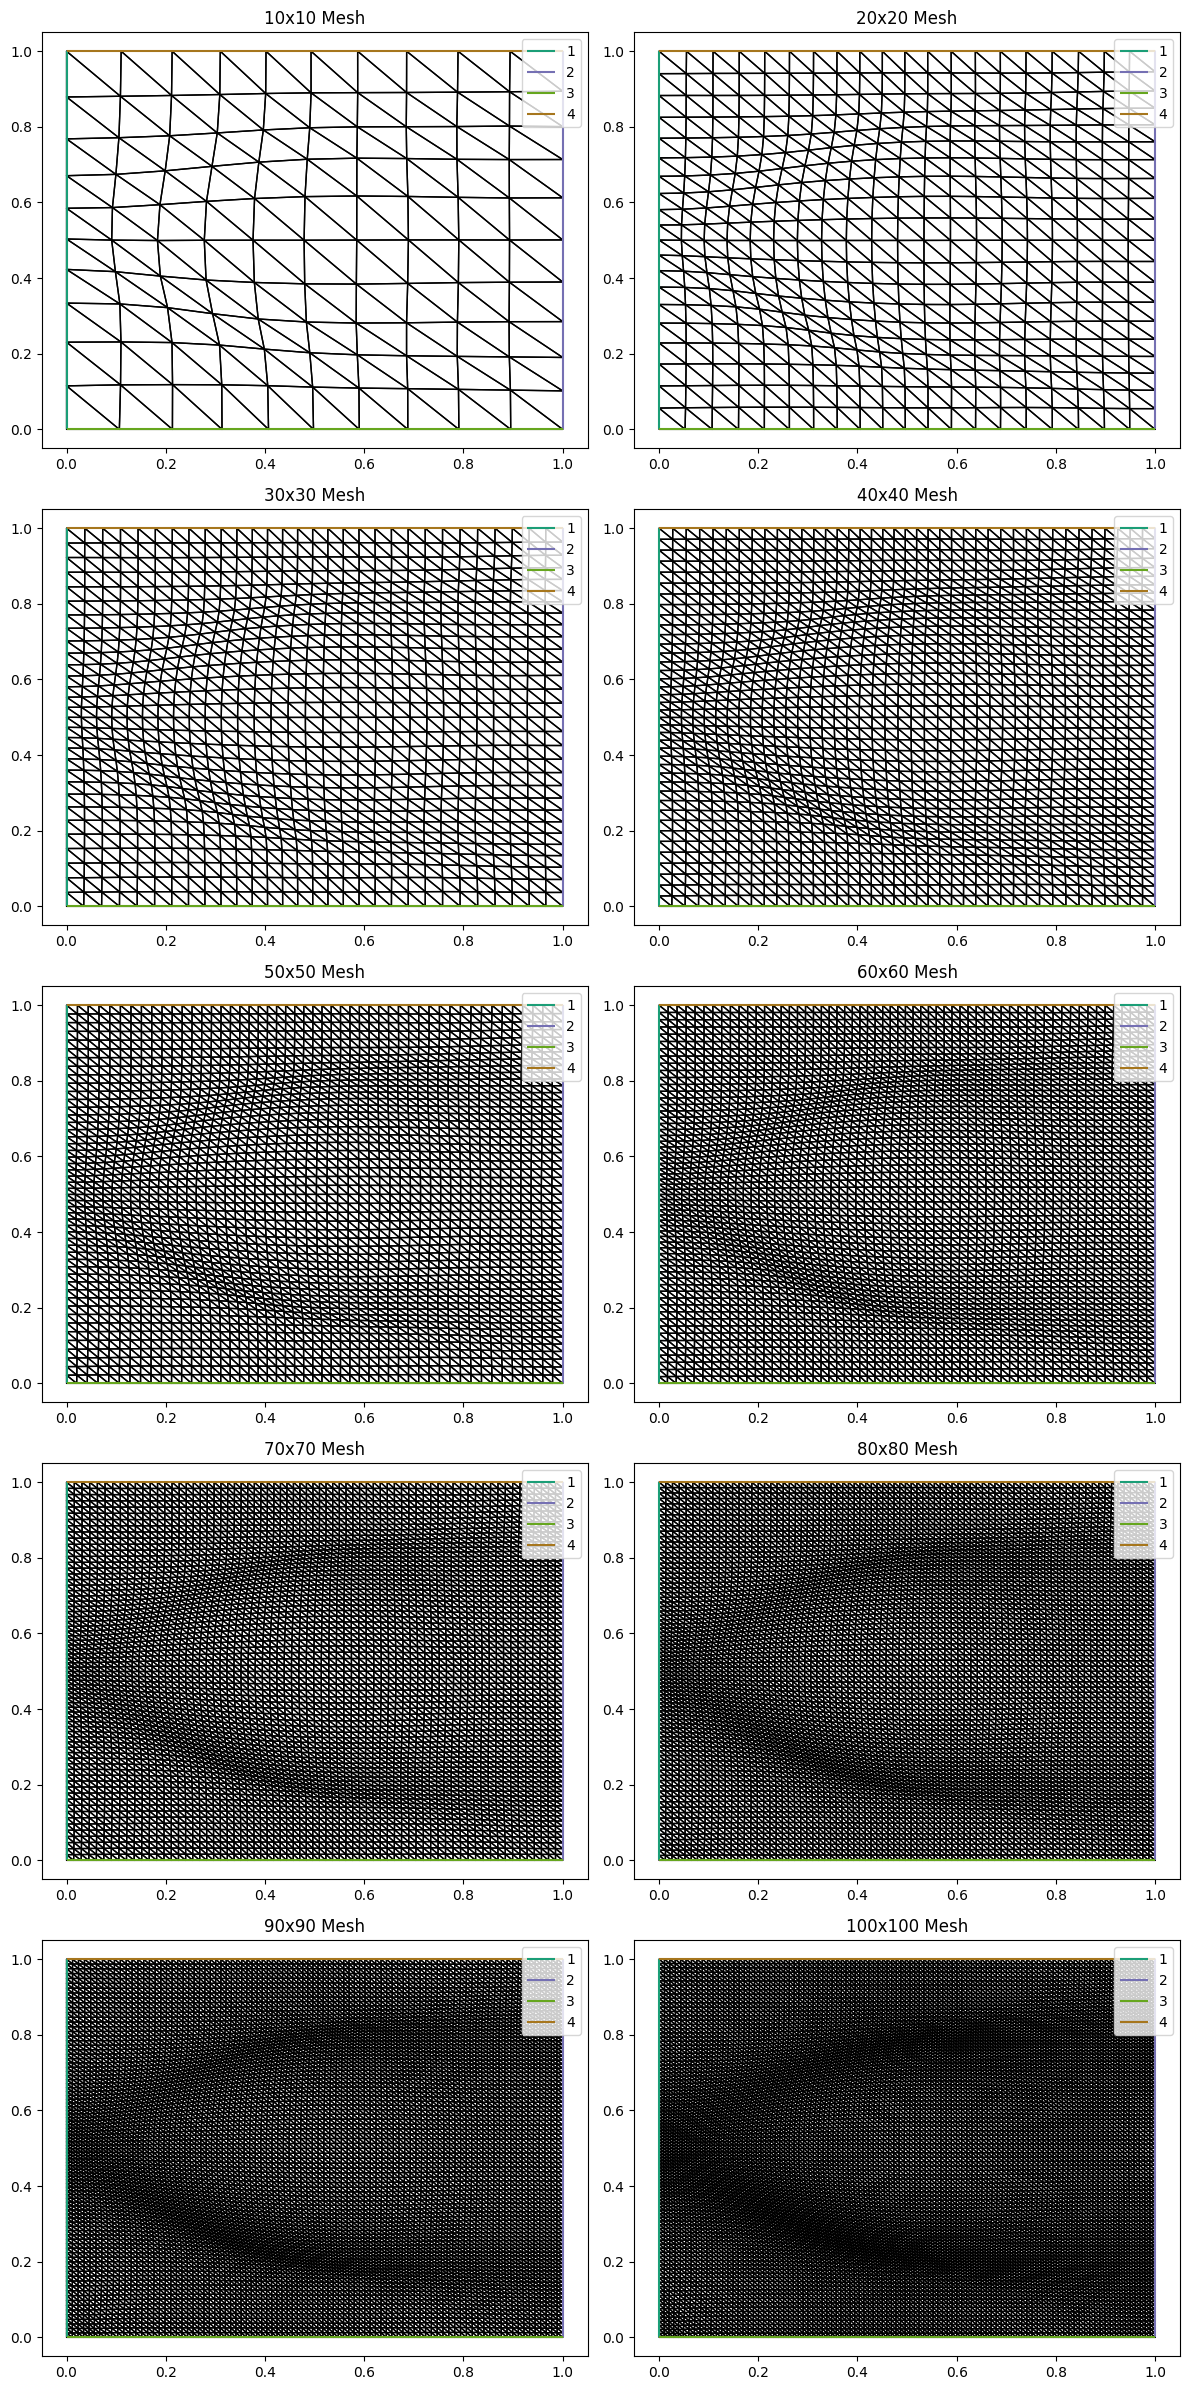

In [242]:
fig, axes = plt.subplots(5, 2, figsize=(12, 24))

for i, ax in enumerate(axes.flatten()):
    triplot(adapted_meshes[i], axes=ax)
    ax.set_title(f"{(i+1)*10}x{(i+1)*10} Mesh")
    ax.legend()

plt.tight_layout()
plt.show()